# MERSCOPE DEGs Analysis

In [1]:
# Import necessary libraries
import sys
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
# import squidpy
import warnings
from shapely import wkt
import numpy as np

project_root = "/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation"
sys.path.append(project_root)
from HELPERs.plotting import create_volcano_plot

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.se

In [2]:
os.chdir(project_root)

base_path = 'DATA/p0-p7/R2'
h5ad_file = os.path.join(base_path, 'data.h5ad')

In [3]:
roi_csv_file_name = 'p0_R2_ROI_28-07-25_11-49_geometry.csv'
roi_geometry_file_path = os.path.join(base_path, roi_csv_file_name)
summary_image_file = os.path.join(base_path, 'summary.png')
plot_enable = True

## 1. Data Loading

In [4]:
adata = sc.read_h5ad(h5ad_file)

In [5]:
keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
print(len(keep_genes))
print(adata.shape[1])

960
960


In [6]:
# Cell boundaries
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
cell_boundaries_gdf = None

In [7]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded DATA/p0-p7/R2/cell_boundaries.parquet. Shape: (379820, 9)


In [8]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
2073004400000100003,0,2073004400000100003,3,"MULTIPOLYGON (((4577.127 213.444, 4577.653 214...",None,None,cell,6.0,None
2073004400000100013,1,2073004400000100013,3,"MULTIPOLYGON (((4700.266 214.565, 4700.113 217...",None,None,cell,6.0,None
2073004400000100014,2,2073004400000100014,3,"MULTIPOLYGON (((4714.439 220.304, 4717.441 218...",None,None,cell,6.0,None
2073004400000100015,3,2073004400000100015,3,"MULTIPOLYGON (((4582.661 213.587, 4584.364 216...",None,None,cell,6.0,None
2073004400000100016,4,2073004400000100016,3,"MULTIPOLYGON (((4628.379 217.812, 4629.837 218...",None,None,cell,6.0,None


# Subselect cells based on ROI polygons from CSV

This section loads ROI polygons from a CSV file, converts them to geometries,
and then selects cells from `cell_boundaries_gdf` that fall within these ROIs.

In [9]:
# Load ROI geometry data from CSV
roi_polygons_df = pd.read_csv(roi_geometry_file_path)
print(f"Successfully loaded ROI geometry file: {roi_geometry_file_path}")
print("ROI CSV Head:")
print(roi_polygons_df.head())

Successfully loaded ROI geometry file: DATA/p0-p7/R2/p0_R2_ROI_28-07-25_11-49_geometry.csv
ROI CSV Head:
  EntityID                                           geometry  \
0     ctrl  POLYGON ((7015.78 2462.07, 7029.55 2389.54, 66...   

                                       dataset        group  
0  202504111150_Sessa-p0-p7_VMSC10702_region_1  Unclustered  


# Process ROI geometries and perform spatial selection

In [10]:
# Convert WKT string geometries to Shapely geometry objects
roi_polygons_df['geometry'] = roi_polygons_df['geometry'].apply(wkt.loads)

# Create a GeoDataFrame from the ROI data
# Assume cell_boundaries_gdf is already defined and has a CRS.
# If cell_boundaries_gdf.crs is None, roi_gdf.crs will also be None,
# which is acceptable if coordinates are in the same arbitrary Cartesian system.
current_crs = None
if 'cell_boundaries_gdf' in locals() and cell_boundaries_gdf is not None and hasattr(cell_boundaries_gdf, 'crs'):
    current_crs = cell_boundaries_gdf.crs
    print(f"Using CRS from cell_boundaries_gdf: {current_crs}")
else:
    print("Warning: cell_boundaries_gdf not found or has no CRS. Assuming planar coordinates for ROIs.")

Using CRS from cell_boundaries_gdf: None


In [11]:
roi_gdf = gpd.GeoDataFrame(roi_polygons_df, geometry='geometry', crs=current_crs)
print("Successfully converted ROI geometries to GeoDataFrame.")
print("ROI GeoDataFrame Head:")
roi_gdf.head()

Successfully converted ROI geometries to GeoDataFrame.
ROI GeoDataFrame Head:


,EntityID,geometry,dataset,group
0,ctrl,"POLYGON ((7015.780 2462.070, 7029.550 2389.540...",202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered


In [12]:
# Perform spatial selection of cells within ROIs
print(f"Shape of cell_boundaries_gdf before spatial join: {cell_boundaries_gdf.shape}")
print(f"Shape of roi_gdf before spatial join: {roi_gdf.shape}")

Shape of cell_boundaries_gdf before spatial join: (379820, 9)
Shape of roi_gdf before spatial join: (1, 4)


In [13]:
# Prepare the left GeoDataFrame for sjoin to avoid 'EntityID' column clash
# The original cell_boundaries_gdf has 'EntityID' as both index and column.
# Renaming the index ensures that when sjoin (or its internal functions)
# calls reset_index(), the new column from the index doesn't conflict.
cell_boundaries_gdf_sjoin_ready = cell_boundaries_gdf.copy()
cell_boundaries_gdf_sjoin_ready.index.name = 'original_cell_EntityID_idx' # Rename the index

In [14]:
# Spatial join: find cells whose geometries are 'within' the ROI polygons
# 'how="inner"' means only cells that are within an ROI are kept.
# 'predicate="within"' checks if cell geometry is entirely within ROI geometry.
# Added lsuffix and rsuffix to handle any potential column name overlaps clearly.
cells_in_rois_gdf = gpd.sjoin(
    cell_boundaries_gdf_sjoin_ready,
    roi_gdf,
    how="inner",
    predicate="within",
    lsuffix='_cell',
    rsuffix='_roi'
)

In [15]:
cells_in_rois_gdf.head()

,ID,EntityID__cell,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name,index__roi,EntityID__roi,dataset,group
original_cell_EntityID_idx,,,,,,,,,,,,,
2073004400040100122,203682,2073004400040100122,3,"MULTIPOLYGON (((6695.158 2344.255, 6697.833 23...",None,None,cell,6.0,None,0,ctrl,202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered
2073004400040100129,203688,2073004400040100129,3,"MULTIPOLYGON (((6706.411 2340.743, 6707.615 23...",None,None,cell,6.0,None,0,ctrl,202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered
2073004400040100143,203700,2073004400040100143,3,"MULTIPOLYGON (((6736.782 2348.267, 6737.266 23...",None,None,cell,6.0,None,0,ctrl,202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered
2073004400040100156,203710,2073004400040100156,3,"MULTIPOLYGON (((6688.785 2347.913, 6689.692 23...",None,None,cell,6.0,None,0,ctrl,202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered
2073004400040100157,203711,2073004400040100157,3,"MULTIPOLYGON (((6701.565 2355.045, 6704.092 23...",None,None,cell,6.0,None,0,ctrl,202504111150_Sessa-p0-p7_VMSC10702_region_1,Unclustered


In [16]:
print(f"\nFound {cells_in_rois_gdf.shape[0]} cells within the defined ROIs.")


Found 819 cells within the defined ROIs.


In [17]:
print("Head of cells_in_rois_gdf (cells spatially selected by ROIs):")
print(cells_in_rois_gdf.head())

Head of cells_in_rois_gdf (cells spatially selected by ROIs):
                                ID       EntityID__cell  ZIndex  \
original_cell_EntityID_idx                                        
2073004400040100122         203682  2073004400040100122       3   
2073004400040100129         203688  2073004400040100129       3   
2073004400040100143         203700  2073004400040100143       3   
2073004400040100156         203710  2073004400040100156       3   
2073004400040100157         203711  2073004400040100157       3   

                                                                     Geometry  \
original_cell_EntityID_idx                                                      
2073004400040100122         MULTIPOLYGON (((6695.158 2344.255, 6697.833 23...   
2073004400040100129         MULTIPOLYGON (((6706.411 2340.743, 6707.615 23...   
2073004400040100143         MULTIPOLYGON (((6736.782 2348.267, 6737.266 23...   
2073004400040100156         MULTIPOLYGON (((6688.785 2347.913, 

In [18]:
# Analyze the selected cells
print("\nCell counts per ROI:")
print(cells_in_rois_gdf.groupby('group').size())


Cell counts per ROI:
group
Unclustered    819
dtype: int64



Cell counts per ROI group (from 'group' column of ROI CSV):
group
Unclustered    819
dtype: int64

Plotting selected cells and ROIs...


/tmp/ipykernel_1952844/2052724004.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


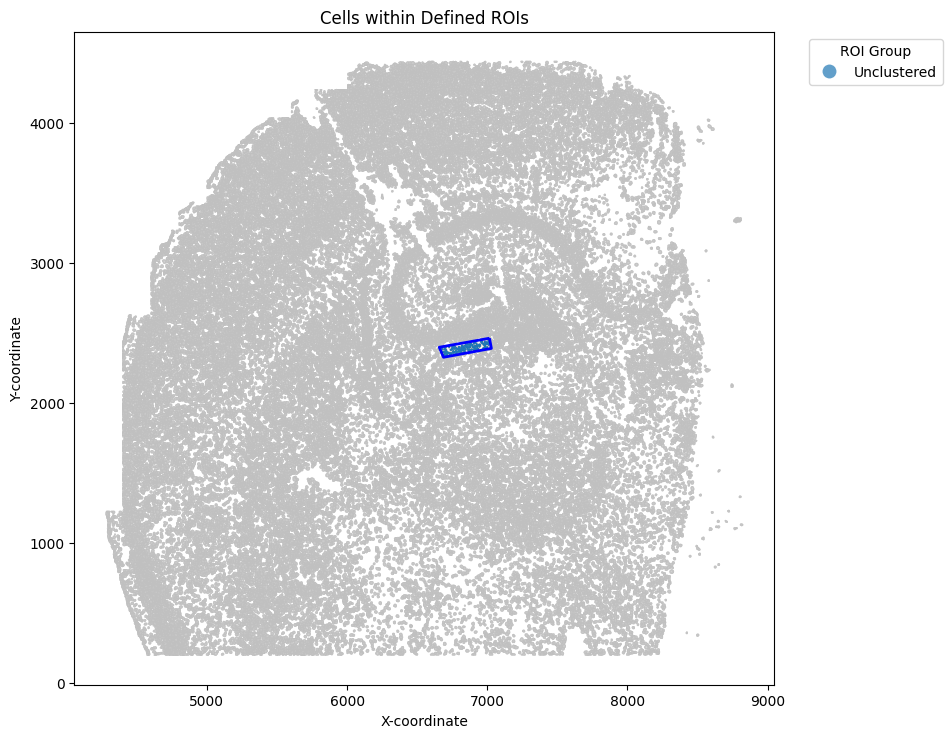

In [19]:
# Visualize selected cells with ROIs

if plot_enable:

    print("\nCell counts per ROI group (from 'group' column of ROI CSV):")
    print(cells_in_rois_gdf.groupby('group').size())

    print("\nPlotting selected cells and ROIs...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot all original cell boundaries lightly
    cell_boundaries_gdf.plot(ax=ax, color='lightgray', edgecolor='silver', alpha=0.3, label='All Cells (Original)')

    unique_groups = cells_in_rois_gdf['group'].nunique()
    cells_in_rois_gdf.plot(ax=ax, column='group', legend=True, alpha=0.7, categorical=True,
                                           legend_kwds={'title': "ROI Group", 'loc': 'upper right', 'bbox_to_anchor': (1.25, 1)})

    # Plot ROI boundaries
    roi_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='ROI Polygons')

    ax.set_title("Cells within Defined ROIs")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")

    # Adjust legend display
    handles, labels = ax.get_legend_handles_labels()

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

<img src="2025-07-28 19_10_46-MERSCOPE Vizualizer (p0_R2).png" alt="MERSCOPE Vizualizer">

# 2. Analyze transcript expression directly within ROIs

Loading transcripts from DATA/p0-p7/R2/detected_transcripts.csv...
Loaded 11602210 transcripts.
Successfully converted transcripts to GeoDataFrame.

Found 17460 transcripts within all ROIs.

--- Analysis for ROI Group: Unclustered ---
Total transcripts in this ROI group: 17460
Top 20 most expressed genes:
gene
Sparcl1    1616
Ubc        1588
Gfap       1096
Atp1a2      468
Aqp4        269
Zbtb20      239
Nfib        224
Gabbr1      212
Vim         172
Ptprs       170
Slc1a2      168
Gria2       163
Cdh5        154
Apoe        142
Apcdd1      135
Fabp7       134
Cldn5       130
Stxbp1      123
Ptprm       122
Huwe1       111
Name: count, dtype: int64


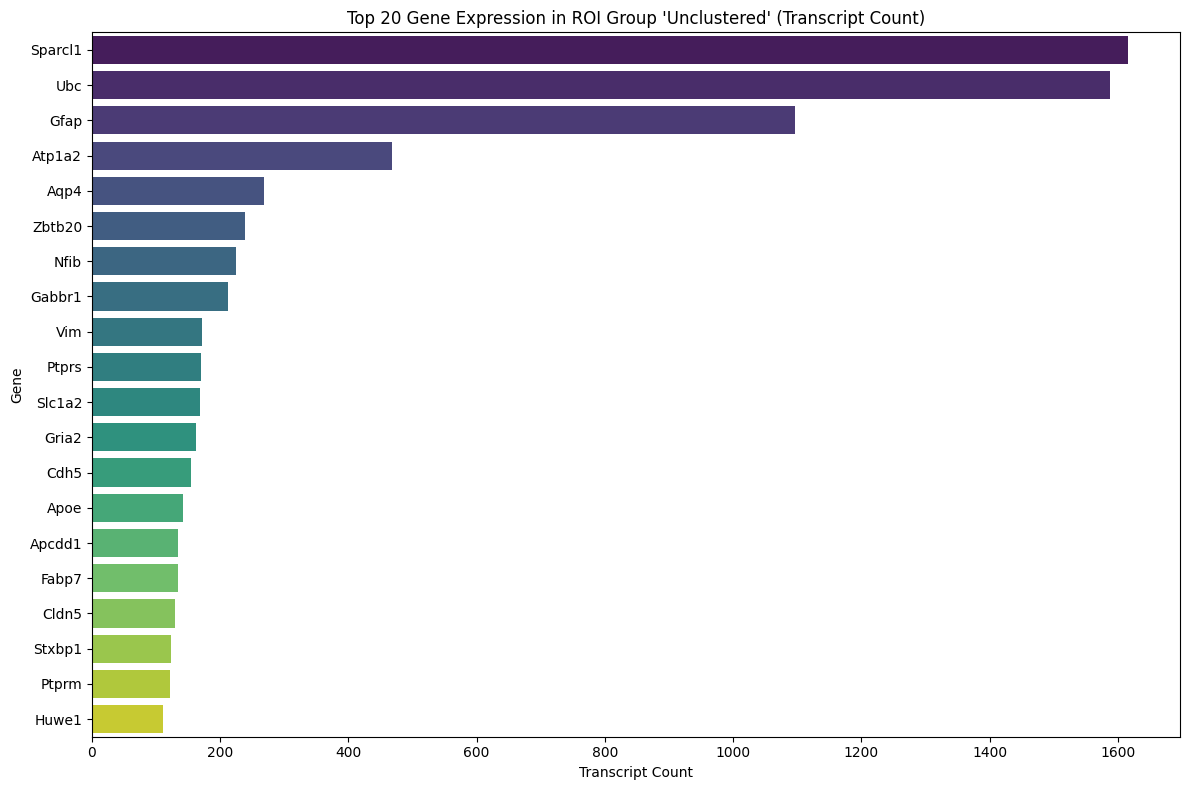

In [20]:
# Load transcript data
# The transcript file is typically named 'detected_transcripts.csv' in Vizgen datasets.
transcripts_file = os.path.join(base_path, 'detected_transcripts.csv')
if os.path.exists(transcripts_file):
    print(f"Loading transcripts from {transcripts_file}...")
    transcripts_df = pd.read_csv(transcripts_file)
    print(f"Loaded {len(transcripts_df)} transcripts.")
    
    # Convert transcripts DataFrame to a GeoDataFrame
    # MERSCOPE data uses 'global_x' and 'global_y' for coordinates.
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df,
        geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y']),
        crs=current_crs  # Use the same CRS as the cell boundaries
    )
    print("Successfully converted transcripts to GeoDataFrame.")

    # Spatially join transcripts with ROIs
    transcripts_in_rois_gdf = gpd.sjoin(transcripts_gdf, roi_gdf, how="inner", predicate="within")
    
    print(f"\nFound {len(transcripts_in_rois_gdf)} transcripts within all ROIs.")

    # Analyze and plot gene expression for each ROI group
    for group_name, group_df in transcripts_in_rois_gdf.groupby('group'):
        print(f"\n--- Analysis for ROI Group: {group_name} ---")
        
        # Get gene counts
        gene_counts = group_df['gene'].value_counts()
        
        print(f"Total transcripts in this ROI group: {len(group_df)}")
        print("Top 20 most expressed genes:")
        print(gene_counts.head(20))
        
        # Plotting
        if plot_enable:
            plt.figure(figsize=(12, 8))
            sns.barplot(x=gene_counts.head(20).values, y=gene_counts.head(20).index, palette="viridis")
            plt.title(f"Top 20 Gene Expression in ROI Group '{group_name}' (Transcript Count)")
            plt.xlabel("Transcript Count")
            plt.ylabel("Gene")
            plt.tight_layout()
            plt.show()
else:
    print(f"Transcript file not found at: {transcripts_file}")
    print("Skipping transcript-level analysis.")